# exp035

In [19]:
import os
import sys
import gc
import itertools
import pickle
import pathlib
import datetime
from dateutil.relativedelta import relativedelta
from dotenv import load_dotenv
load_dotenv()
sys.path.append(os.getenv('UTILS_PATH'))

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

import line_notify

In [20]:
import builtins
import types

def imports():
    for name, val in globals().items():
        # module imports
        if isinstance(val, types.ModuleType):
            yield name, val

            # functions / callables
        if hasattr(val, '__call__'):
            yield name, val


def noglobal(f):
    '''
    ref: https://gist.github.com/raven38/4e4c3c7a179283c441f575d6e375510c
    '''
    return types.FunctionType(f.__code__,
                              dict(imports()),
                              f.__name__,
                              f.__defaults__,
                              f.__closure__
                              )

In [21]:
SEED = 42
N_ITER = 1
RUN_INF = True # 推論処理を行うか
BATCH_SIZE = int(5e5)

In [22]:
Ns = {}
Ns['cf_a'] = 12
Ns['ctf_a'] = 12
Ns['atfd_a'] = 12
Ns['atfp_a'] = 12
Ns['pa_a'] = 12

Ns['cf_w'] = 12
Ns['ctf_w'] = 12
Ns['atfd_w'] = 12
Ns['atfp_w'] = 12
Ns['pa_w'] = 12

Ns['cf_m'] = 12
Ns['ctf_m'] = 12
Ns['atfd_m'] = 12
Ns['atfp_m'] = 12
Ns['pa_m'] = 12

Ns['cf_y'] = 12
Ns['ctf_y'] = 12
Ns['atfd_y'] = 12
Ns['atfp_y'] = 12
Ns['pa_y'] = 12

ディレクトリ設定

In [23]:
INPUT_DIR = os.getenv('INPUT_DIR')
OUTPUT_DIR = os.getenv('OUTPUT_DIR')
#exp_name = os.path.dirname(__file__).split('/')[-1]
exp_name = 'exp035'
os.makedirs(OUTPUT_DIR + exp_name, exist_ok=True)

データ読み込み

In [24]:
articles = pd.read_csv(INPUT_DIR + 'articles.csv', dtype='object')
customers = pd.read_csv(INPUT_DIR + 'customers.csv')
transactions = pd.read_csv(INPUT_DIR + 'transactions_train.csv', dtype={'article_id':'str'}, parse_dates=['t_dat'])
sample = pd.read_csv(INPUT_DIR + 'sample_submission.csv')

# 前処理

In [25]:
ALL_CUSTOMER = customers['customer_id'].unique().tolist()
ALL_ARTICLE = articles['article_id'].unique().tolist()

customer_ids = dict(list(enumerate(ALL_CUSTOMER)))
article_ids = dict(list(enumerate(ALL_ARTICLE)))

customer_map = {u: uidx for uidx, u in customer_ids.items()}
article_map = {i: iidx for iidx, i in article_ids.items()}

articles['article_id'] = articles['article_id'].map(article_map)
customers['customer_id'] = customers['customer_id'].map(customer_map)
transactions['article_id'] = transactions['article_id'].map(article_map)
transactions['customer_id'] = transactions['customer_id'].map(customer_map)
sample['customer_id'] = sample['customer_id'].map(customer_map)

In [26]:
# 名寄せ
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.replace('None','NONE')

In [27]:
customers['age10'] = str((customers['age'] // 10) * 10)
customers.loc[customers['age'].isnull(), 'age10'] = np.nan

In [28]:
# label_encoding
le_cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
for c in le_cols:
    le = LabelEncoder()
    articles[c] = le.fit_transform(articles[c].fillna(''))


le_cols = ['club_member_status', 'fashion_news_frequency', 'postal_code', 'age10']
for c in le_cols:
    le = LabelEncoder()
    customers[c] = le.fit_transform(customers[c].fillna(''))

In [29]:
customers['customer_type'] = customers['FN'].fillna(0).astype(int).astype(str) + \
                             customers['Active'].fillna(0).astype(int).astype(str) + \
                             customers['club_member_status'].fillna(0).astype(int).astype(str) + \
                             customers['fashion_news_frequency'].fillna(0).astype(int).astype(str) + \
                             customers['age10'].fillna(0).astype(int).astype(str)

le = LabelEncoder()
customers['customer_type'] = le.fit_transform(customers['customer_type'])

In [30]:
# transactionに紐づけ
transactions = transactions.merge(customers, on='customer_id', how='left')
transactions = transactions.merge(articles, on='article_id', how='left')

# データセット作成（レコメンド→対象データセット作成→特徴量エンジニアリング）

In [31]:
@noglobal
def get_customer_frequent(history, n=12, timedelta=None):
    """顧客ごと商品の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        dataframe: 抽出結果
    """
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()
        
    customer_agg = history.groupby(['customer_id', 'article_id'])['t_dat'].count().reset_index()
    customer_agg = customer_agg.rename(columns={'t_dat':'cnt'})
    customer_agg = customer_agg.sort_values(['customer_id', 'cnt'], ascending=False)
    result = customer_agg.groupby('customer_id').head(n)
    return result[['customer_id', 'article_id']]

@noglobal
def get_popular_article(history, n=12, timedelta=None):
    """全体の購入数をカウントし上位の商品を抽出

    Args:
        history (dataframe): 集計対象の実績データ
        n (int): レコメンド対象とする数
        timedelta (dateutil.relativedelta): 指定された場合、実績データの終端からtimedelta分のデータを取得する

    Returns:
        list: 抽出結果
    """
    # 全体の購入数量
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    total_agg = history.groupby('article_id')['t_dat'].count().reset_index()
    total_agg = total_agg.rename(columns={'t_dat':'cnt'})
    total_agg = total_agg.sort_values(['cnt'], ascending=False)
    total_agg = total_agg.head(n)
    result = list(total_agg['article_id'].values)
    return result

@noglobal
def get_customer_type_frequent(history, n=12, timedelta=None):
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    result = history[['customer_id', 'customer_type']].drop_duplicates().copy()
    agg = history.groupby(['customer_type', 'article_id'])['t_dat'].count().reset_index()
    agg = agg.rename(columns={'t_dat':'cnt'})
    agg = agg.sort_values(['customer_type', 'cnt'], ascending=False)
    agg = agg.groupby('customer_type').head(n)
    result = result.merge(agg[['customer_type', 'article_id']], on='customer_type', how='left')
    return result[['customer_id', 'article_id']]

@noglobal
def get_article_type_frequent(history, col, n=12, timedelta=None):
    if timedelta is not None:
        st_date = history['t_dat'].max() - timedelta
        history = history[history['t_dat']>=st_date].copy()

    result = history.groupby(['customer_id', col])['t_dat'].count().reset_index()
    result = result.rename(columns={'t_dat':'cnt'})
    result = result.sort_values(['customer_id', 'cnt'], ascending=False)
    result = result.groupby(['customer_id']).head(1)[['customer_id', col]]

    agg = history.groupby([col, 'article_id'])['t_dat'].count().reset_index()
    agg = agg.rename(columns={'t_dat':'cnt'})
    agg = agg.sort_values([col, 'cnt'], ascending=False)
    agg = agg.groupby(col).head(n)
    result = result.merge(agg[[col, 'article_id']], on=col, how='left')
    return result[['customer_id', 'article_id']]

@noglobal
def get_reccomend(target_customer_id, history, Ns):
    n = 12
    result = pd.DataFrame()
    

    td = None
    result = result.append(get_customer_frequent(history, Ns['cf_a'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_a'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_a'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_a'], td))
    popular_article = get_popular_article(history, Ns['pa_a'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)
    result = result.drop_duplicates()

    td = relativedelta(weeks=1)
    result = result.append(get_customer_frequent(history, Ns['cf_w'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_w'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_w'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_w'], td))
    popular_article = get_popular_article(history, Ns['pa_w'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)
    result = result.drop_duplicates()

    td = relativedelta(months=1)
    result = result.append(get_customer_frequent(history, Ns['cf_m'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_m'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_m'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_m'], td))
    popular_article = get_popular_article(history, Ns['pa_m'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)
    result = result.drop_duplicates()

    td = relativedelta(years=1)
    result = result.append(get_customer_frequent(history, Ns['cf_y'], td))
    result = result.append(get_customer_type_frequent(history, Ns['ctf_y'], td))
    result = result.append(get_article_type_frequent(history, 'department_name', Ns['atfd_y'], td))
    result = result.append(get_article_type_frequent(history, 'perceived_colour_master_name', Ns['atfp_y'], td))
    popular_article = get_popular_article(history, Ns['pa_y'], td)
    # customerとpopular articleの全組み合わせでdataframe作成
    popular_article = pd.DataFrame(itertools.product(target_customer_id, popular_article), columns=['customer_id', 'article_id'])
    result = result.append(popular_article)
    result = result.drop_duplicates()

    result = result[result['customer_id'].isin(target_customer_id)].copy()

    return result

In [32]:
@noglobal
def add_labels(recom_result, history):
    """レコメンドしたデータが学習期間で購入されたかどうかのフラグを付与する

    Args:
        recom_result (_type_): レコメンド結果
        train_tran (_type_): 学習期間のトランザクションデータ

    Returns:
        _type_: 学習期間での購入フラグを付与したレコメンド結果
    """
    history = history[['customer_id', 'article_id']].drop_duplicates()
    history['buy'] = 1
    recom_result = recom_result.merge(history, on=['customer_id', 'article_id'], how='left')
    recom_result['buy'] = recom_result['buy'].fillna(0)
    return recom_result


In [33]:
@noglobal
def make_article_features(articles):
    cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']
    return articles[['article_id']+cols]

@noglobal
def make_article_tran_features(history):
    df = history.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std']}).reset_index()
    df.columns = ['article_id','article_total_cnt', 'article_total_latest_buy', 'article_total_1st_buy', 'article_price_max', 'article_price_min', 'article_price_mean', 'article_age_max', 'article_age_min', 'article_age_mean', 'article_age_std']
    df['article_total_1st_buy'] = (history['t_dat'].max() - df['article_total_1st_buy']).dt.days
    df['article_total_latest_buy'] = (history['t_dat'].max() - df['article_total_latest_buy']).dt.days

    history_1weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=7)) & 
                                   (history['t_dat'] <= history['t_dat'].max())]

    history_1weekago_df = history_1weekago.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std', 'median']}).reset_index()
    history_1weekago_df.columns = ['article_id','article_total_cnt_1weekago', 'article_total_latest_buy_1weekago', 'article_total_1st_buy_1weekago', 'article_price_max_1weekago', 'article_price_min_1weekago', 'article_price_mean_1weekago', 'article_age_max_1weekago', 'article_age_min_1weekago', 'article_age_mean_1weekago', 'article_age_std_1weekago', 'article_age_median_1weekago']
    history_1weekago_df['article_total_1st_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['article_total_1st_buy_1weekago']).dt.days
    history_1weekago_df['article_total_latest_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['article_total_latest_buy_1weekago']).dt.days

    df = pd.merge(df,history_1weekago_df,how='left',on='article_id')

    del history_1weekago, history_1weekago_df
    gc.collect()

    history_2weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=14)) & 
                                   (history['t_dat'] <= history['t_dat'].max() - relativedelta(days=7))]

    history_2weekago_df = history_2weekago.groupby('article_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'], 
                                            'age':['max', 'min', 'mean', 'std', 'median']}).reset_index()
    history_2weekago_df.columns = ['article_id','article_total_cnt_2weekago', 'article_total_latest_buy_2weekago', 'article_total_1st_buy_2weekago', 'article_price_max_2weekago', 'article_price_min_2weekago', 'article_price_mean_2weekago', 'article_age_max_2weekago', 'article_age_min_2weekago', 'article_age_mean_2weekago', 'article_age_std_2weekago', 'article_age_median_2weekago']
    history_2weekago_df['article_total_1st_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['article_total_1st_buy_2weekago']).dt.days
    history_2weekago_df['article_total_latest_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['article_total_latest_buy_2weekago']).dt.days

    df = pd.merge(df,history_2weekago_df,how='left',on='article_id')

    del history_2weekago, history_2weekago_df
    gc.collect()

    return df


@noglobal
def make_customer_features(customers):
    return customers

@noglobal
def make_customer_tran_features(history):
    group = ['Ladieswear', 'Divided', 'Menswear', 'Sport', 'Baby/Children']
    for g in group:
        history[g] = 0
        history.loc[history['index_group_name']==g, g] = 1


    df = history.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'],
                                            'Ladieswear':'sum',
                                            'Divided':'sum',
                                            'Menswear':'sum',
                                            'Sport':'sum',
                                            'Baby/Children':'sum'}).reset_index()
    df.columns = ['customer_id','customer_total_cnt', 'customer_total_latest_buy', 'customer_total_1st_buy', 
                  'customer_price_max', 'customer_price_min', 'customer_price_mean',
                  'Ladieswear', 'Divided', 'Menswear', 'Sport', 'Baby/Children']
    df['customer_total_1st_buy'] = (history['t_dat'].max() - df['customer_total_1st_buy']).dt.days
    df['customer_total_latest_buy'] = (history['t_dat'].max() - df['customer_total_latest_buy']).dt.days

    for g in group:
        df[g] = df[g] / df['customer_total_cnt']

#####################iida_exp24#########################
    history_1weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=7)) & 
                                   (history['t_dat'] <= history['t_dat'].max())]
    history_1weekago_df =  history_1weekago.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'],
                                            'Ladieswear':'sum',
                                            'Divided':'sum',
                                            'Menswear':'sum',
                                            'Sport':'sum',
                                            'Baby/Children':'sum'}).reset_index() 
    history_1weekago_df.columns = ['customer_id','customer_total_cnt_1weekago', 'customer_total_latest_buy_1weekago', 'customer_total_1st_buy_1weekago', 
                                'customer_price_max_1weekago', 'customer_price_min_1weekago', 'customer_price_mean_1weekago',
                                'Ladieswear_1weekago', 'Divided_1weekago', 'Menswear_1weekago', 'Sport_1weekago', 'Baby/Children_1weekago']

    history_1weekago_df['customer_total_1st_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['customer_total_1st_buy_1weekago']).dt.days
    history_1weekago_df['customer_total_latest_buy_1weekago'] = (history_1weekago['t_dat'].max() - history_1weekago_df['customer_total_latest_buy_1weekago']).dt.days

    for g in group:
        history_1weekago_df[g+'_1weekago'] = history_1weekago_df[g+'_1weekago'] / history_1weekago_df['customer_total_cnt_1weekago']

    df = pd.merge(df,history_1weekago_df,how='left',on='customer_id')

    history_2weekago = history.loc[(history['t_dat'] > history['t_dat'].max() - relativedelta(days=14)) & 
                                   (history['t_dat'] <= history['t_dat'].max() - relativedelta(days=7))]
    history_2weekago_df =  history_2weekago.groupby('customer_id').agg({'t_dat':['count', 'max', 'min'],
                                            'price':['max', 'min', 'mean'],
                                            'Ladieswear':'sum',
                                            'Divided':'sum',
                                            'Menswear':'sum',
                                            'Sport':'sum',
                                            'Baby/Children':'sum'}).reset_index() 
    history_2weekago_df.columns = ['customer_id','customer_total_cnt_2weekago', 'customer_total_latest_buy_2weekago', 'customer_total_1st_buy_2weekago', 
                                'customer_price_max_2weekago', 'customer_price_min_2weekago', 'customer_price_mean_2weekago',
                                'Ladieswear_2weekago', 'Divided_2weekago', 'Menswear_2weekago', 'Sport_2weekago', 'Baby/Children_2weekago']

    history_2weekago_df['customer_total_1st_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['customer_total_1st_buy_2weekago']).dt.days
    history_2weekago_df['customer_total_latest_buy_2weekago'] = (history_2weekago['t_dat'].max() - history_2weekago_df['customer_total_latest_buy_2weekago']).dt.days

    for g in group:
        history_2weekago_df[g+'_2weekago'] = history_2weekago_df[g+'_2weekago'] / history_2weekago_df['customer_total_cnt_2weekago']

    df = pd.merge(df,history_2weekago_df,how='left',on='customer_id')

    del history_2weekago, history_2weekago_df
    gc.collect()

    return df

@noglobal
def make_customer_article_features(target, history):
    df = target.merge(history, on=['customer_id', 'article_id'], how='inner')
    df = df.groupby(['customer_id', 'article_id']).agg({'t_dat':['count', 'min', 'max']}).reset_index()
    df.columns = ['customer_id', 'article_id', 'count', '1st_buy_date_diff', 'latest_buy_date_diff']
    df['1st_buy_date_diff'] = (history['t_dat'].max() - df['1st_buy_date_diff']).dt.days
    df['latest_buy_date_diff'] = (history['t_dat'].max() - df['latest_buy_date_diff']).dt.days
    return df

@noglobal
def add_same_article_type_rate(target, history, col):
    add_data = history[['customer_id', col]].copy()
    add_data['total'] = add_data.groupby('customer_id').transform('count')
    add_data = add_data.groupby(['customer_id', col])['total'].agg(['max', 'count']).reset_index()
    add_data[f'{col}_customer_buy_rate'] = add_data['count'] / add_data['max']
    target = target.merge(add_data[['customer_id', col, f'{col}_customer_buy_rate']], on=['customer_id', col], how='left')
    return target

    

@noglobal
def add_features(df, history, articles, customers):
    df = df.merge(make_article_features(articles), on=['article_id'], how='left')
    df = df.merge(make_article_tran_features(history), on=['article_id'], how='left')
    df = df.merge(make_customer_features(customers), on=['customer_id'], how='left')
    df = df.merge(make_customer_tran_features(history), on=['customer_id'], how='left')
    df = df.merge(make_customer_article_features(df[['customer_id', 'article_id']], history), on=['article_id', 'customer_id'], how='left')

    cols = ['product_type_name', 'product_group_name', 'graphical_appearance_name',
            'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name',
            'index_name', 'index_group_name', 'section_name', 'garment_group_name']

    for c in cols:
        df = add_same_article_type_rate(df, history, c)

    return df
    

# レコメンド商品を購入するかどうかの2値分類モデル

In [34]:
def apk(y_true, y_pred, K=12):
    assert(len(y_true) == len(y_pred))
    apks = []
    for idx in range(len(y_true)):
        y_i_true = y_true[idx]
        y_i_pred = y_pred[idx]

        # 予測値の数と重複の確認
        assert(len(y_i_pred) <= K)
        assert(len(np.unique(y_i_pred)) == len(y_i_pred))

        sum_precision = 0.0
        num_hits = 0.0

        for i, p in enumerate(y_i_pred):
            if p in y_i_true:
                num_hits += 1
                precision = num_hits / (i+1)
                sum_precision += precision
        apk = sum_precision / min(len(y_i_true), K)
        apks.append(apk)
    return apks

In [35]:
params = {
    "objective": "binary",
    "boosting" : "gbdt",
    "learning_rate": 0.01,
    "metric": "binary_logloss",
    "seed": SEED
}

In [36]:
# 1週ずつローリングして学習データを生成し検証
train_start = datetime.datetime(2020,9,9)
valid_start = datetime.datetime(2020,9,16)
valid_end = datetime.datetime(2020,9,22)

fi = pd.DataFrame()
scores = []
for i in range(N_ITER):
    # 学習データの作成
    history_tran = transactions[transactions['t_dat'] < train_start].copy()
    target_tran = transactions[(transactions['t_dat'] >= train_start) & (transactions['t_dat'] < valid_start)].copy()
    target_id = target_tran['customer_id'].unique().tolist()
    recom = get_reccomend(target_id, history_tran, Ns)
    ml_train = add_labels(recom, target_tran)
    ml_train = add_features(ml_train, history_tran, articles, customers)

    # 評価データの作成
    history_tran = transactions[transactions['t_dat'] < valid_start].copy()
    target_tran = transactions[(transactions['t_dat'] >= valid_start) & (transactions['t_dat'] <= valid_end)].copy()
    target_id = target_tran['customer_id'].unique().tolist()
    recom = get_reccomend(target_id, history_tran, Ns)
    ml_valid = add_labels(recom, target_tran)
    ml_valid = add_features(ml_valid, history_tran, articles, customers)
    
    target = 'buy'
    not_use_cols = ['customer_id', 'article_id', target]
    features = [c for c in ml_train.columns if c not in not_use_cols]

    # 学習
    tr_x, tr_y = ml_train[features], ml_train[target]
    vl_x, vl_y = ml_valid[features], ml_valid[target]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                    num_boost_round=20000, early_stopping_rounds=100,verbose_eval=1000)

    # 特徴量重要度
    fi_tmp = pd.DataFrame()
    fi_tmp['iter'] = N_ITER
    fi_tmp['feature'] = model.feature_name()
    fi_tmp['importance'] = model.feature_importance(importance_type='gain')
    fi = fi.append(fi_tmp)

    # cv
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    # 正解データ作成
    valid = transactions[(transactions['t_dat'] >= valid_start) & (transactions['t_dat'] <= valid_end)].copy()
    valid = valid[['customer_id', 'article_id']].drop_duplicates()
    valid = valid.groupby('customer_id')['article_id'].apply(list).reset_index()
    valid = valid.sort_values('customer_id').reset_index(drop=True)
    # 2値分類の出力を元に12個選定
    valid_pred = ml_valid[['customer_id', 'article_id']].copy()
    valid_pred['prob'] = vl_pred
    valid_pred = valid_pred.sort_values(['customer_id', 'prob'], ascending=False)
    valid_pred = valid_pred.groupby('customer_id').head(12)
    valid_pred = valid_pred.groupby('customer_id')['article_id'].apply(list).reset_index()
    valid_pred = valid_pred.sort_values('customer_id').reset_index(drop=True)
    assert(valid['customer_id'].tolist() == valid_pred['customer_id'].tolist())
    # MAP@12
    score = np.mean(apk(valid['article_id'].tolist(), valid_pred['article_id'].tolist()))
    print(f'{valid_start.strftime("%Y-%m-%d")} - {valid_end.strftime("%Y-%m-%d")} : ' + '{:.5f}'.format(score))
    scores.append(score)

    ml_valid['pred'] = vl_pred
    ml_valid.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_oof{i}.csv', index=False)

    with open(OUTPUT_DIR + f'{exp_name}/model{i}.pickle', 'wb') as f:
        pickle.dump(model, f)

    train_start = train_start - relativedelta(days=7)
    valid_start = valid_start - relativedelta(days=7)
    valid_end = valid_end - relativedelta(days=7)
cv_score = np.mean(scores)
print(f'MAP@12 : ' + '{:.5f}'.format(cv_score))

/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 17205, number of negative: 5587936
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.740905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12388
[LightGBM] [Info] Number of data points in the train set: 5605141, number of used features: 98
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003070 -> initscore=-5.783165
[LightGBM] [Info] Start training from score -5.783165
Training until validation scores don't improve for 100 rounds
[1000]	training's binary_logloss: 0.015881	valid_1's binary_logloss: 0.0186435
[2000]	training's binary_logloss: 0.0148363	valid_1's binary_logloss: 0.018627
Early stopping, best iteration is:
[2260]	training's binary_logloss: 0.0146059	valid_1's binary_logloss: 0.0186248
2020-09-16 - 2020-09-22 : 0.03142
MAP@12 : 0.03142


In [37]:
scores

[0.03141720258125862]

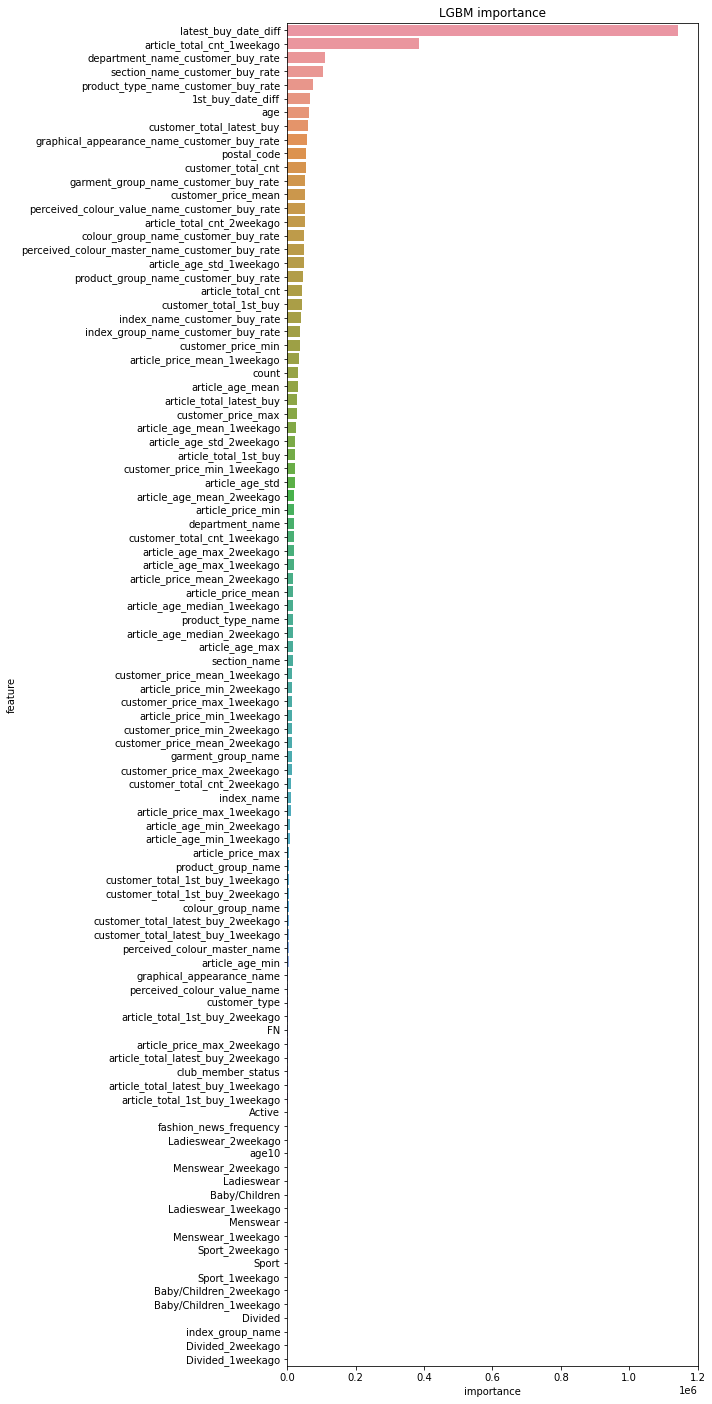

In [38]:
fi_n = fi['feature'].nunique()
order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, fi_n*0.2))
sns.barplot(x="importance", y="feature", data=fi, order=order)
plt.title(f"LGBM importance")
plt.tight_layout()
plt.savefig(OUTPUT_DIR + f'{exp_name}/lgbm_importance.png')

In [39]:
del history_tran, target_tran, target_id, recom
del ml_train, ml_valid, tr_x, tr_y, vl_x, vl_y, tr_data, vl_data, valid, valid_pred
gc.collect()

22503

# sub

In [40]:
if RUN_INF:
    # テストデータの作成
    all_target_id = sample['customer_id'].tolist()

    # メモリのケアのためバッチで推論を回す
    batchs = [all_target_id[i:i+BATCH_SIZE] for i in range(0, len(all_target_id), BATCH_SIZE)]
    
    preds = []
    
    for target_id in batchs:
        recom = get_reccomend(target_id, transactions, Ns)
        ml_test = add_features(recom, transactions, articles, customers)

        test_pred = np.zeros(len(ml_test))
        models = pathlib.Path(OUTPUT_DIR + f'{exp_name}').glob('model*.pickle')

        for m in models:
            with open(m, 'rb') as f:
                model = pickle.load(f)
        test_pred += model.predict(ml_test[features], num_iteration=model.best_iteration) / N_ITER

        test = ml_test[['customer_id', 'article_id']].copy()
        test['prob'] = test_pred
        test = test.sort_values(['customer_id', 'prob'], ascending=False)
        test = test.groupby('customer_id').head(12)
        preds.append(test)
    
    del recom, ml_test, test_pred
    gc.collect()

    test = pd.concat(preds)
    test['article_id'] = test['article_id'].map(article_ids)
    test['customer_id'] = test['customer_id'].map(customer_ids)

    test = test.groupby('customer_id')['article_id'].apply(list).reset_index()

    sub = sample['customer_id'].map(customer_ids).to_frame()
    sub = sub.merge(test, on=['customer_id'], how='left')
    sub = sub.rename(columns={'article_id':'prediction'})
    assert(sub['prediction'].apply(len).min()==12)
    sub['prediction'] = sub['prediction'].apply(lambda x: ' '.join(x))
    sub.to_csv(OUTPUT_DIR + f'{exp_name}/{exp_name}_sub.csv', index=False)
    

In [41]:
sub.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0568601043 0915529003 0924243002 06...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0714790020 0448509014 0915529003 0706016001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0901666001 0924243001 0794321008 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471043 0918522001 0918292001 0791587001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0730683050 0924243002 0791587015 06...


In [42]:
message = f'{exp_name} is finished!\nvalid_score : {cv_score}'
line_notify.send(message)